In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, make_axis_great_again, plot_epochs

In [4]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '29.04_06.05_scaling-up'

= found 34 / 34 training / validation epochs
- plotted metrics [11.8, 17.7] in epochs [0, 33]
- plotted metrics [23.7, 26.5] in epochs [0, 33]
= found 14 / 14 training / validation epochs
- plotted metrics [12.8, 15.1] in epochs [0, 13]
- plotted metrics [24.0, 27.5] in epochs [0, 13]


Text(0.5, 0.98, 'Algebraic, PRE-TRAINED BB (optimizing just alg_confidences, deconv_layers and final_layer), lr=1e-6 on 11872 / 703 images ~ 384 x 384 pixels')

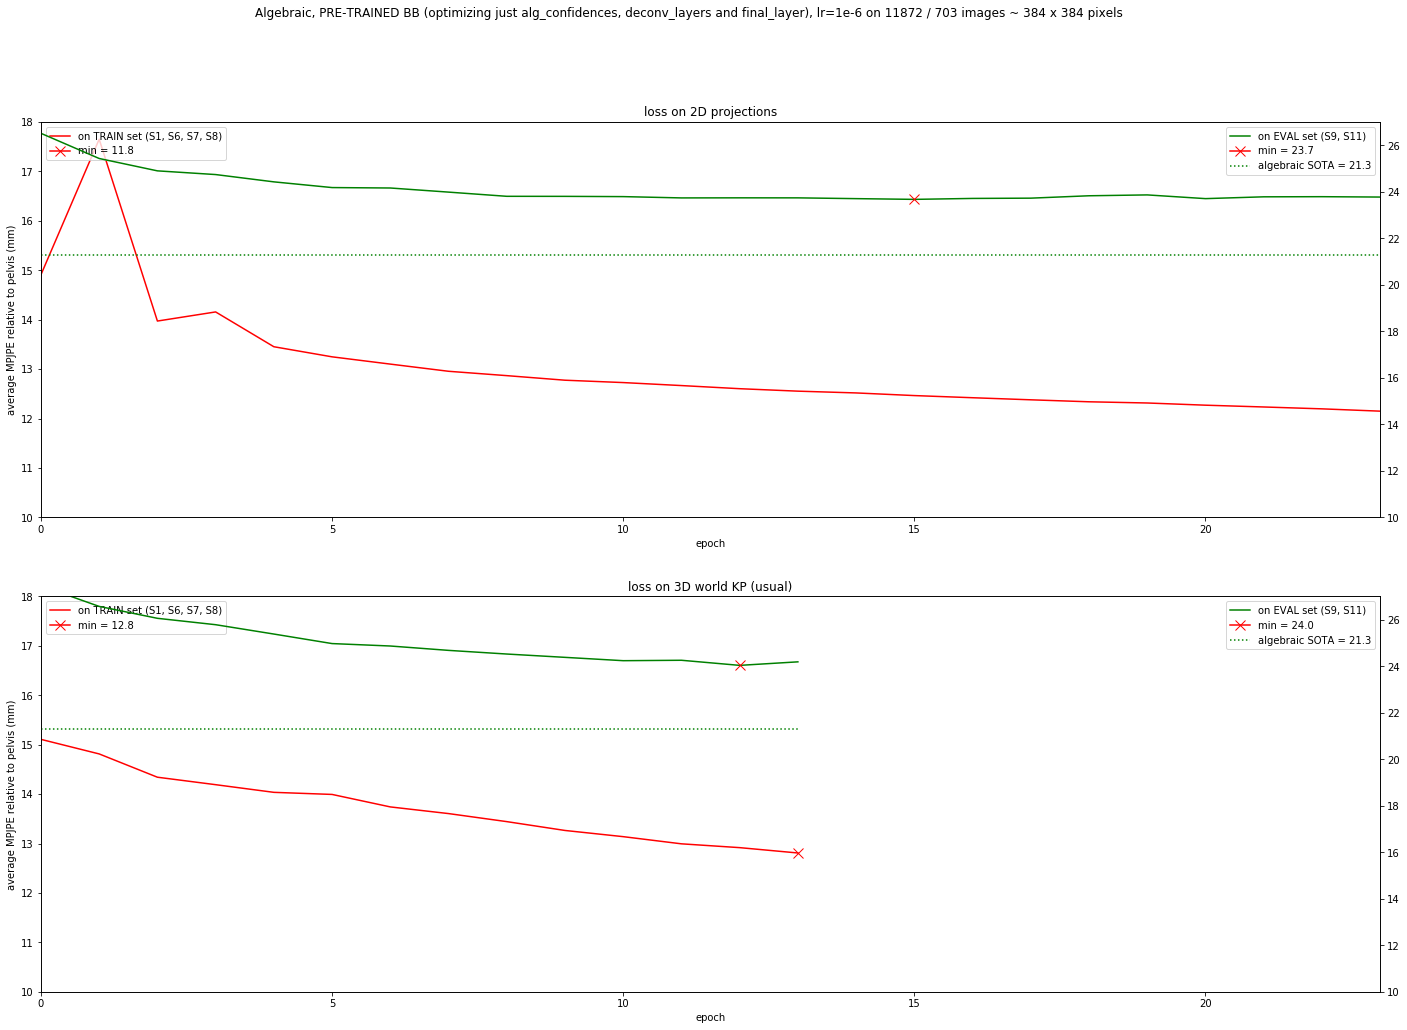

In [69]:
fig, axis = get_figa(2, 1, heigth=8, width=24)

train_ylim = [10, 18]
eval_ylim = [10, 27]

train_metrics, eval_metrics = parse_metrics_log(current_milestone / '2d.txt')
ax = axis.ravel()[0]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)
make_axis_great_again(
    ax,
    title='loss on 2D projections',
    left_title='average MPJPE relative to pelvis (mm)',
    xlim=[0, 23],
    ylim=train_ylim
)
ax.grid(False)

train_metrics, eval_metrics = parse_metrics_log(current_milestone / '3d.txt')
ax = axis.ravel()[1]
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=train_ylim, eval_ylim=eval_ylim)
make_axis_great_again(
    ax,
    title='loss on 3D world KP (usual)',
    left_title='average MPJPE relative to pelvis (mm)',
    xlim=[0, 23],
    ylim=train_ylim
)
ax.grid(False)

fig.suptitle('Algebraic, PRE-TRAINED BB (optimizing just alg_confidences, deconv_layers and final_layer), lr=1e-6 on 11872 / 703 images ~ 384 x 384 pixels')
# long_optim_2d_VS_3d.png

In [ ]:
exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '14193307.out')
fig, axis = get_figa(2, 1, heigth=8, width=24)

plot_epochs(
    axis, epochs,
    train_metric_ylim=[1e2, 20 * 1e2],
    eval_metric_ylim=[1e2, 20 * 1e2],
    loss_ylim=[3 * 1e5, 10 * 1e5],
    loss_ylabel='loss = geodesic + 0.01 * L2 translation',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)

fig.suptitle('cam2cam estimation on S1 (23 training / 3 validation images), using 2D GT projections, lr=1e-4')
# cam2cam.png